In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import *
from scipy.integrate import odeint
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from Code.TensorFlowProject_code import *

<h1><center>Utlizing a Multi-Layer Perceptron to Find Initial Conditions of a Damped One Dimensional Spring</center></h1>

<center>By: Nick Schwartz </center>

# Abstract

Background: The one dimensional spring is a well known physics problem that has multiple different analyzable cases making it ideal for a proof of concept machine learning project.

Purpose: Create a model that can accurately predict the k and b values for a damped spring. All three cases of damping are possible with the generated data.

Methods: The model and the optimizer will be varied to determine the optimal one. The data was created using Odeint.

Results: Adam and Adamax were the most effective optimizers, both tested models were comparably effective. The k and b values were able to be accurately perdicted.

Conclusion: A proof of concept was given, but a much more complex model may still yet not be possible with this approach.

# Background

The one dimensional spring has multiple cases, over, under, and critical damping. When analyzing the system being able to predict the kind of damping is important. They are predicted from the relationship between $b^2$ and $4mk$ Below are the solutions:

# Case 1: Critical Damping 
### $b^2 = 4mk$

Critical Damping has the general solution as follows:

$$ x(t) = C_1e^{\lambda_1t} +C_2te^{\lambda_1t} $$

$$ \text{with}\hspace{2mm}\lambda_1 = -\dfrac{b}{2m}$$

# Case 2: Over Damping 
### $b^2 > 4mk$

Over Damping has the general solution as follows:

$$ x(t) =  C_1e^{\lambda_1t} +C_2e^{\lambda_2t} $$

$$ \text{with}\hspace{2mm} \lambda_1 = -\dfrac{-b + \sqrt{b^2-4mk}}{2m}, \hspace{2mm} \lambda_2 = -\dfrac{-b - \sqrt{b^2-4mk}}{2m} $$

# Case 3: Under Damping 
### $b^2 < 4mk$

Under Damping has the general solution as follows:

$$x(t) = C_1e^{\alpha \hspace{1mm} t}\cos(\beta \hspace{1mm} t)+C_2e^{\alpha \hspace{1mm} t}\sin(\beta \hspace{1mm} t)$$

$$ \text{with}\hspace{2mm} \alpha = -\dfrac{b}{2m}, \hspace{2mm} \beta = \dfrac{\sqrt{4mk-b^2}}{2m}$$


In all three cases the general solutions are determined by the m, k, and b values. Therefore with this system, training a model to predict these parameters can be used to classify damping. The m value being the least important because it is a scalar that acts as a scaling variable.

This sort of problem is referred to in the literature by "inverse problems" where you take physical data and try to discover unknown parameters of a physical system (Hao et al. 2022).

# Motivation

The goal of this project is to be able to predict the k (spring constant) and b (damping constant) values of a damped one dimensional spring. In this project due to time constraints the chosen problem is admittedly simplified, but still useful in illustrating that physical parameters can be found from position and velocity data. In order to create the Neural Network, tensorflow-keras will be utilized. The purpose of this goal is to be able to look at real life spring analogous systems and predict the k and b values of those systems. In order to do this a large plethora of varied data with varied starting constants will be needed. Since such a dataset is not readily available, it will need to be created. The creation of the dataset here adds bias to the model, but unfortunately there is not another option given the lack of available data.

The benefit to doing this project is that such a model could be used to analyze experimental data. Essentially, the model would be able to look at observed behavior and then predict the experimental values that created the behavior. This is important because it can reduce the overhead needed to analyze experimental results, saving both time and money. The long term goal of the project is to showcase that inverse problems can be useful in real life applications.

# Methods

### Creation of the Dataset

In order to create a dataset large enough, about 10,000 entries, a method will need to be devised in order to create varied, non-duplicate, and limitedly biased data. Using previous experiences of creating generated spring data from previous projects covering damped harmonic motion, reasonable k values to be between 1 and 15 and reasonable b values to be between 0 and 1. From these ranges of values numpy arrays were arranged with small step sizes to create a total possible number of combinations totalling 30,000. Through this, random k and b values can be randomly selected and plugged into odeint to generate varied data of time, position, and velocity data for each of the 10,000 randomly sampled constants.

Below is an example of some of the data behaviors:

<br>
<center><img src="Images/data_example.png"></center>
<br>

The above shows that there are a varied amount of behaviors in the data set, in the appendix you can run the code used to generate this plot (graph_random_data()) and see the varied behaviors in the dataset. Importantly, the data created has bias because of the constrained k and b values with an assumed m value of one. The m value is not as impactful because it functions as a scaling of the dataset, and the input data is normalized before being input into the model regardless. Therefore, assuming the real world data being predicted is within the no damping to heavy damping cases with any mass it should be able to be estimated when considering the data being normalized.

### The Differential Equation

For damped harmonic motion the differential equation will be:

$$ 0 = m\ddot{x}+ b\dot{x} + kx$$

This is the equation that will be passed to odeint from Scipy in order to generate the data. Since m scales the data due to affecting both terms equally, it will be held at a constant value of 1. This won't have a large impact on how the model performs for new real world data because the data should be normalized like the data being trained here will be.

### Model Selection

For this project there will be two candidate models that will be compared using 5 k-fold cross validation. The first will be a standard MLP which will have multiple layers with descending node numbers. The second model will have the same amount of layers as the first, but every layer except the last one will be fully connected layers. These models were chosen for the simplicity due to hardware and time concerns. More models would increase runtime and comparisons by an incredible amount

The "best model" will be chosen based on consistency and overall loss performance. Due to the size the of the loss being expected to me less than 1, RMSE error will be used because MSE would make the loss seem smaller than it actually is, where RMSE shows the actually average loss across all the predictions. The best model will have an associated best optimizer that will be selected for each model.

The other thing to keep in mind here is that the magnitude differences between the K and B value will drag up the error of the b values. When looking individually at the numbers, the error separately may be larger or smaller than the overall RMSE respectively. An example of the predicted versus real values will be printed in the appendix. In the end the RMSE will be a good enough estimate of the model efficacy even if it doesn't completely get the context of the difference in magnitude of the two physical parameters.

### Loss Function Creation

Since the data is in a somewhat odd format in the output, the RMSE function will be created to evaluate the predictions. This ensures that the loss is what it is expected to be. The function can be seen in the .py file with the name "calc_test_RMSE". This loss function was selected because the error is expected to be less than one. For errors less than one, the mean squared error will make the loss seem smaller than it actually is. Therefore to get a better understanding of how far off the model is with its' predictions, RMSE is the better choice that is just a converted version of MSE which is the standard regression loss function.

### Optimizer Selections

In order to verify that the best optimizer for the project has been chosen, all non-experimental and applicable optimizers provided by the keras package will be tested on the two models. Explanations of the models are below:

Adam: stochastic gradient descent (SGD) with adaptive first order and second order moments

Adadelta: SGD method that is used to address two drawbacks: the continual decay of learning rates through training, and the need for a manually selected global learning rate

Adamax: variant of adam based on the infinity norm

Adagrad: parameter specific learning rates

SGD: gradient descent with momentum optimizer

The rest of the optimizers provided by keras are either labeled as experimental or not applicible to this specific problem. All the optimizers will be initialized with the same learning rate, and trained for the same amount of epochs for each k-fold test.

The best optimizer for each tested model will be chosen based on both the best loss and the consistency across the k-fold validation. The reasoning for choosing not only on the best score is that there can be outliers based on how the data is trained, so for this kind of application, consistency is much more important when choosing the best optimizer.

### ML Package and Hardware

The machine learning package to be used for this project is tensorflow. The reason for this is two-fold, with Pytorch the data needs to be converted to pytorch tensors. However, Tensorflow can be used simply with Numpy arrays and the data that was created for this project is in the form of Numpy arrays because it was generated with Odeint from Scipy. The other is the obvious ability for tensorflow to utilize both Nvidia GPUs and the apple M1 chip which has GPU capabilities for machine learning as well.

The project is developed on both a m1 macbook air, and a windows desktop with a RTX3070 and i-7 12700-kf cpu.

On the windows machine, tensorflow 2.10.0 tensorflow-gpu 2.10.0, cudnn 8.1.0.77, and cudatoolkit 11.2.2 which are all compatible with the RTX3070 Nvidia graphics card. Depending on graphics card different versions may be needed or the GPU component of tensorflow may not even work.

On the apple machine, tensorflow-macos 2.9.0 and tensorflow-metal 0.5 were utilized on the m1 macbook air. The m1 chip is a CPU, but the architecture allows for GPU like processing when it comes to machine learning. Tensorflow has this integrated, but the version of metal and tensorflow-macos need to be compatible with the overall operating system as well.

Both machines utilize GPU or GPU-like components, but the windows machine with the RTX 3070 runs much faster. Therefore, unless using a higher end macbook, a dedicated NVIDIA GPU is recommended for running the code in the appendix.

# Results

Below is an example of how the model is trained. As can be seen below it very quickly gets to less than 1 RMSE, but due to the scale of the graph the incremental changes from about 0.4 to around 0.2 RMSE cannot be seen very clearly. When testing on the testing data, the model does not start to overfit until after about 300 epochs depending heavily on the optimizer chosen. Some optimizers performed wildly better than others regardless of the amount of epochs trained. This is probably due to some of the optimizers not being a good choice for this problem. None of the tested optimizers performed terribly, but as noted, two performed way better.

<br>
<center><img src="Images/loss_example.png"></center>
<br>

Above the plot shows a sharp decrease in loss and then a slow burn of a decrease in loss afterwards as epochs reach the 100 to 500 range. Due to this, the amount of epochs was capped at 500 due to overfitting concerns.

Both models were tested for the best RMSE across common epoch numbers of 100, 200, 300, 400, and 500. Below are the two best outcomes for both the fully connected and descending model.

The fully connected model with the Adamax optimizer performed the best when trained for 500 epochs and the descending model performed similarly but minorly worse with the Adam optimizer when trained for 300 epochs. Both optimizers results are shown below:

The descending model with the Adam optimizer performed the best when trained for 300 epochs and is shown below:

<br>
<center><img src="Images/CV_descending_adam.png"></center>
<br>

The fully connected model with the Adam optimizer performed the best when trained for 500 epochs and is shown below:

<br>
<center><img src="Images/CV_fullconnected_adam.png"></center>
<br>

The descending model with the Adamax optimizer performed the best when trained for 500 epochs and is shown below:

<br>
<center><img src="Images/CV_descending_adamax.png"></center>
<br>

The fully connected model with the Adamax optimizer performed the best when trained for 500 epochs and is shown below:

<br>
<center><img src="Images/CV_fullconnected_adamax.png"></center>
<br>

All of these are fairly similar in their great performance in terms of RMSE. They could all be used as the deployment mode, but if a model must be chosen, the Adamax optimizer with the fully connected model would be the one chosen.

The rest of the outcomes of the tests of the epoch training can be seen in the Appendix along with the runtimes from utilizing the CUDA functionality of the NVIDIA RTX 3070. They are mostly not comparable in terms of RMSE where Adam and Adamax are far and above the rest of the pack. 

From this, both models' best loss scores are fairly similar across the different levels, but the descending node model consistently had better scores across the cross validation levels. The Adam and Adamax optimizer is by and far away the best of the tested, and considering it has an RMSE of <0.04  at the worst, other optimizers should not be considered utilizing for this project since minimal if any improvement can be made on this due to the size of the parameters being estimated by the model. The Adam and Adamax performed well and above the rest of the optimizers for both models. All other tests and graphs and be seen in the appendix. The majority of the other optimizers besides Adam and Adamax performed similarly to each other across the tested epochs.

# Discussion

From the exploration of this project, the method laid out in Hao et al. 2022, an inverse problem was successfully solved, albeit in a simplified case due to time constraints. For the 1d spring, the most important physical constants of a specific problem are the spring constant k and the damping constant b. In order to have data that resembles traditional spring behavior, the k and b values were constrained during data creation in order to not get behaviors that would not typically be seen if this model were to be applied to experimental data. The MLP was able to very accurately predict the k and b values of this simulated system. From above, the RMSE is less than 0.04 across a 5 k-fold cross validation when trained for 500 epochs.

The Adam and Adamax optimizers worked across the board more efficiently and more effectively than the other optimizers. Even when training for fewer epochs (100 v 300) the Adam optimizer performed better in terms of RMSE. As can be seen in the Appendix, the Adam model also doesn't overfit when training for longer (900 epochs), however, there was almost no improvement in RMSE when considering the increase in training time. Therefore, if computational cost is an issue, Adam and or Adamax is the best of the optimizers tested because it can get similar results with less computational cost. 

The natural extension of this project would be using real world data to predict more complex systems. Theoretically, a model could be pre-trained on a similar simulated dataset in order to have it be more effective at predicting real world data. Essentially, train on simulated data, train on known real data, and then estimate the target unknown data with similar behaviors. This would allow for the efficient evaluation of experimental data as long as you know beforehand what the system is.

Something else to consider here is computational cost when finding the best optimizer. When running all the k-fold validiations, it took tensorflow utilizing the cuda cores of an RTX3070 over 10 hours to complete. Without access to a GPU, TPU, or similar system, the process of hyperparameter tuning would be very computationally expensive. Furthermore, with a more complex system, a more complex model may be needed. The model tested in this project had about 1 million trainable parameters, but it can obviously get much more complex than that which would heavily impact computational cost.

# Conclusion

The goal of the project was achieved, a model was trained that could very accurately predict the one dimensional spring with damping case. The model was able to predict physical constants just based on position and velocity behavior. Utilizing fully connected layers is less effective than more complex models from the testing of different MLP architectures and optimizers. Starting with a higher number of nodes and steadily decreasing them continuously performed better with the same amount of epochs and optimizers. The model would be able to classify the damping cases as well since that is a simple inequality of $b^2=4mk$.

This project is a proof of concept of what can be done with deep learning in predicting experimental constants, and with the proper datasets, more complex experimental constants could theoretically be predicted numerically using machine learning.

Something the project failed to do is prove a model could be trained for a more complex system. In order to create data Odeint or a similar differential equation solver must be used. This limits the scope to first order and first order coupled differential equations which are all that Odeint can work with. However, if there was data created a different way with known solved values a very similar approach should work.

# Sources:

Hao, Z., Liu, S., Zhang, Y., Ying, C., Feng, Y., Su, H., & Zhu, J. (2022). Physics-Informed Machine Learning: A Survey on Problems, Methods and Applications. arXiv preprint arXiv:2211.08064.

Multilayer perceptrons for digit recognition with core apis &nbsp;: &nbsp; Tensorflow Core. TensorFlow. (n.d.). Retrieved April 2nd, 2023, from https://www.tensorflow.org/guide/core/mlp_core#the_dense_layer 

Taylor, J. R. (2005). Classical Mechanics. University Science Books. 

# Appendix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import *
from scipy.integrate import odeint
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from Code.TensorFlowProject_code import *

### Code Generating Data

The code directly below is the code that was used to generate the data utilized in this project. The code can be rerun to create new data to verify that any data used will perform similarly.

k_vals = np.arange(1,15.05,0.05)
b_vals = np.arange(0,1.01,0.01)
k_val = np.random.choice(k_vals)
b_val = np.random.choice(b_vals)
xs, vs, ts = odeintway_damp(1,0,k_val,1,b_val,0.1,60)
data = np.array([np.array(np.vstack([xs,vs]))])
targets = np.array([np.array([[k_val],[b_val]])])
for i in range(9999):
    k_val = np.random.choice(k_vals)
    b_val = np.random.choice(b_vals)

    xs, vs, ts = odeintway_damp(1,0,k_val,1,b_val,0.1,60)
    int_data = np.array([np.vstack([xs,vs])])

    data = np.vstack([data,int_data])
    targets = np.vstack([targets,np.array([np.array([[k_val],[b_val]])])])

np.save('data_tf',data,allow_pickle=True)
np.save('targets_tf',targets,allow_pickle=True)

In [3]:
with open('Data/data_tf.npy','rb') as f: # imports data
    data = np.load(f)
with open('Data/targets_tf.npy','rb') as f:
    targets = np.load(f)

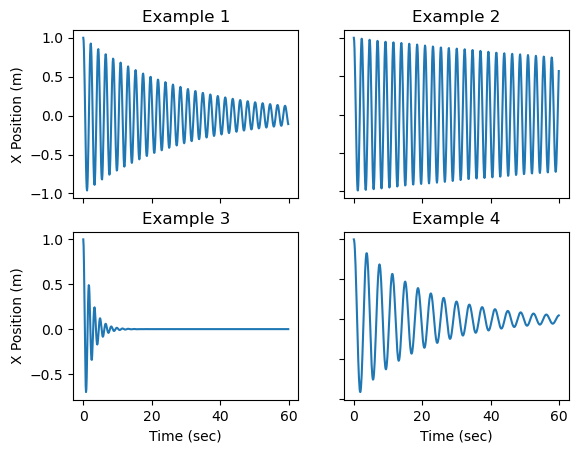

In [12]:
graph_random_data(data) # graphs random data from the dataset

In [5]:
data_normalizer = layers.Normalization(axis=-1)
data_normalizer.adapt(data)
MLP_model = build_and_compile_model(data_normalizer,tf.keras.optimizers.SGD)
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 600)        1201      
 n)                                                              
                                                                 
 dense (Dense)               (None, None, 600)         360600    
                                                                 
 dense_1 (Dense)             (None, None, 500)         300500    
                                                                 
 dense_2 (Dense)             (None, None, 400)         200400    
                                                                 
 dense_3 (Dense)             (None, None, 300)         120300    
                                                                 
 dense_4 (Dense)             (None, None, 200)         60200     
                                                        

In [4]:
start = time.time()
history = MLP_model.fit(data[:8000],targets[:8000],validation_split=0.2,verbose=0,epochs=10)
end = time.time()
print(end-start)

10.308134078979492


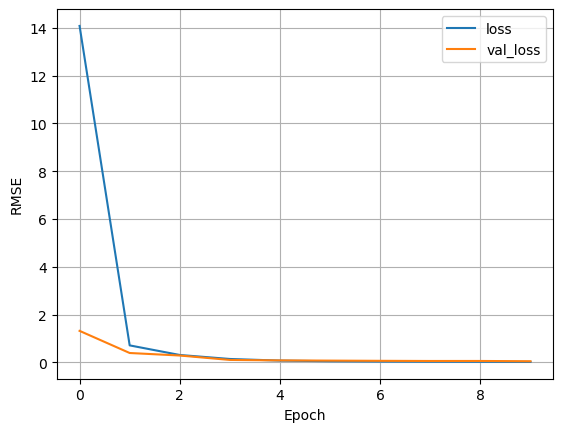

In [5]:
plot_loss(history)

In [6]:
test_predictions = MLP_model.predict(data[8000:])

63/63 [==============================] - 0s 2ms/step


In [7]:
calc_test_RMSE(test_predictions,targets[8000:])

0.20126000088914026

In [8]:
test_predictions

array([[[10.179721  ],
        [ 0.7319826 ]],

       [[11.19259   ],
        [ 0.76192045]],

       [[12.697054  ],
        [ 0.45494926]],

       ...,

       [[ 6.4698954 ],
        [ 0.817093  ]],

       [[ 5.482195  ],
        [ 0.35394487]],

       [[ 7.3892803 ],
        [ 0.1834408 ]]], dtype=float32)

In [9]:
targets[8000:]

array([[[10.1 ],
        [ 0.72]],

       [[11.1 ],
        [ 0.74]],

       [[12.65],
        [ 0.47]],

       ...,

       [[ 6.45],
        [ 0.84]],

       [[ 5.4 ],
        [ 0.35]],

       [[ 7.45],
        [ 0.2 ]]])

63/63 [==============================] - 0s 2ms/step


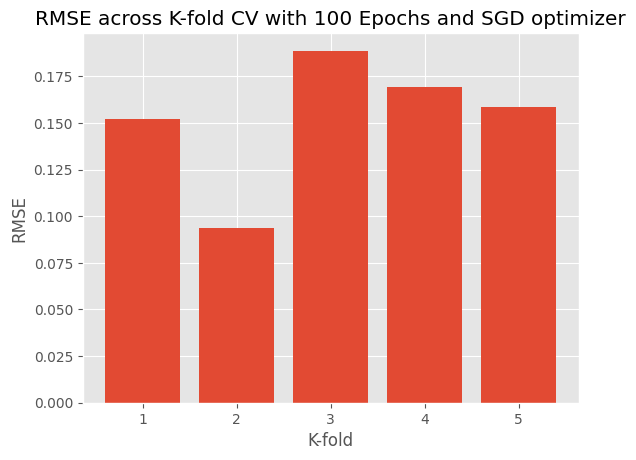

Task Runtime:  2.66  minutes
Total Runtime:  2.66  minutes
63/63 [==============================] - 0s 2ms/step


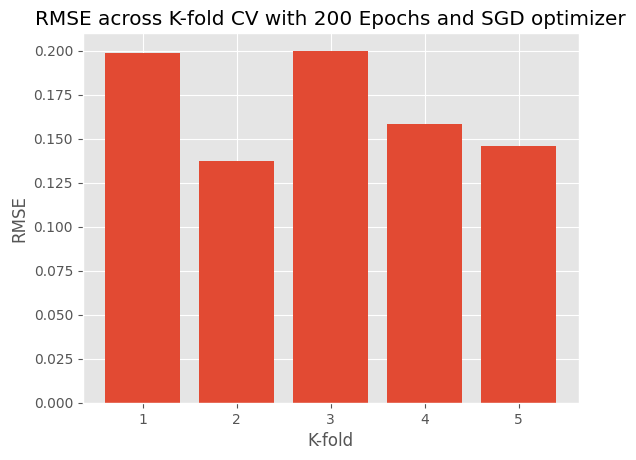

Task Runtime:  5.48  minutes
Total Runtime:  8.14  minutes
63/63 [==============================] - 0s 2ms/step


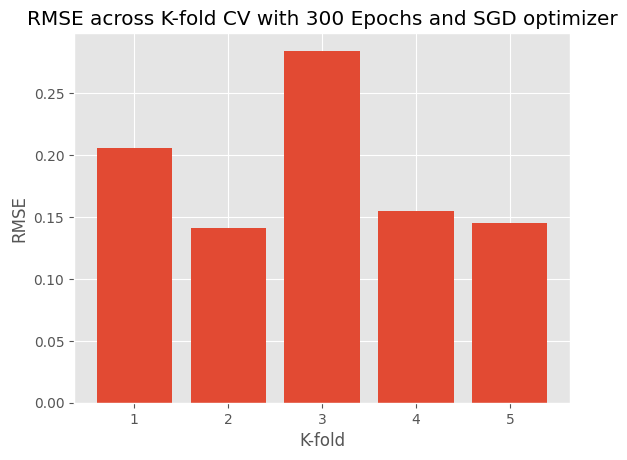

Task Runtime:  8.24  minutes
Total Runtime:  16.38  minutes
63/63 [==============================] - 0s 2ms/step


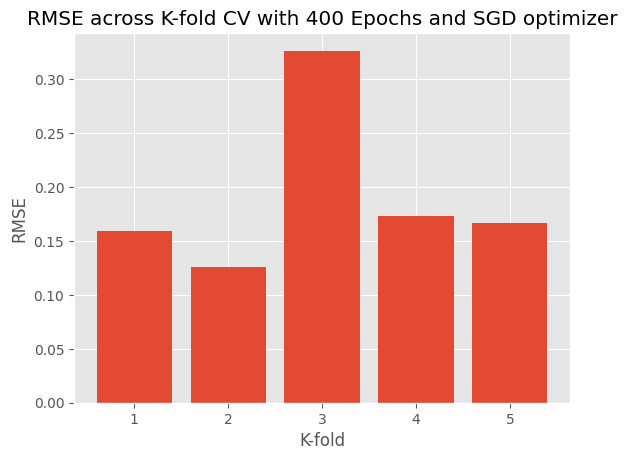

Task Runtime:  10.82  minutes
Total Runtime:  27.21  minutes
63/63 [==============================] - 0s 2ms/step


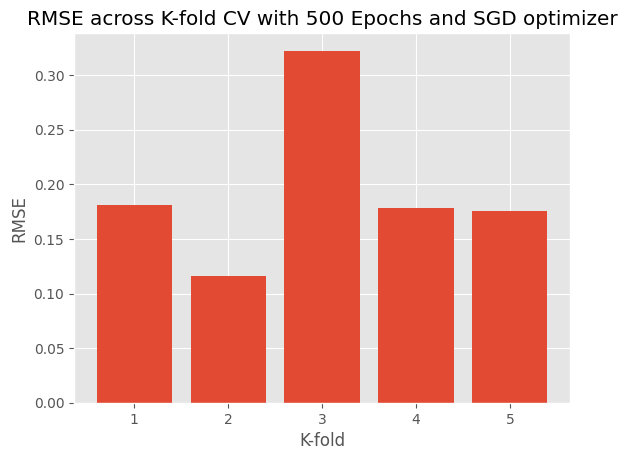

Task Runtime:  13.75  minutes
Total Runtime:  40.95  minutes


In [7]:
run_epoch_comparison(build_and_compile_model,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.SGD,optim_name='SGD',cv=5)

63/63 [==============================] - 0s 2ms/step


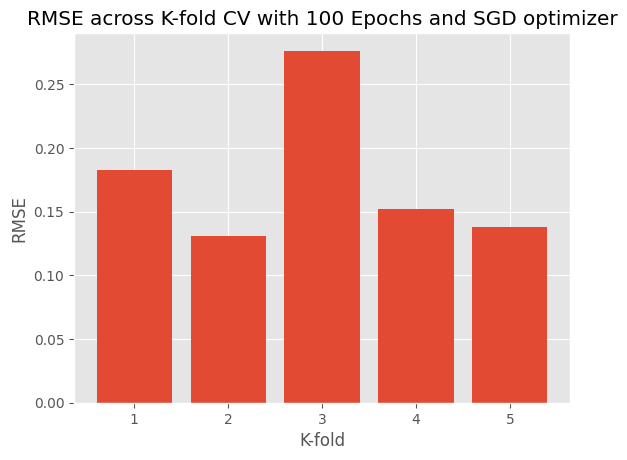

Task Runtime:  2.88  minutes
Total Runtime:  2.88  minutes
63/63 [==============================] - 0s 2ms/step


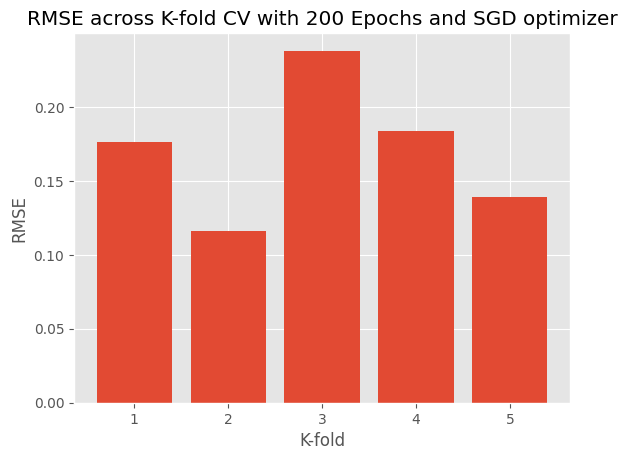

Task Runtime:  5.62  minutes
Total Runtime:  8.5  minutes
63/63 [==============================] - 0s 2ms/step


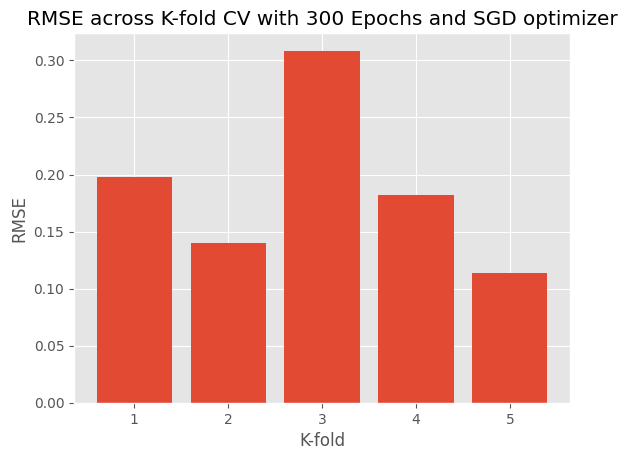

Task Runtime:  8.39  minutes
Total Runtime:  16.89  minutes
63/63 [==============================] - 0s 2ms/step


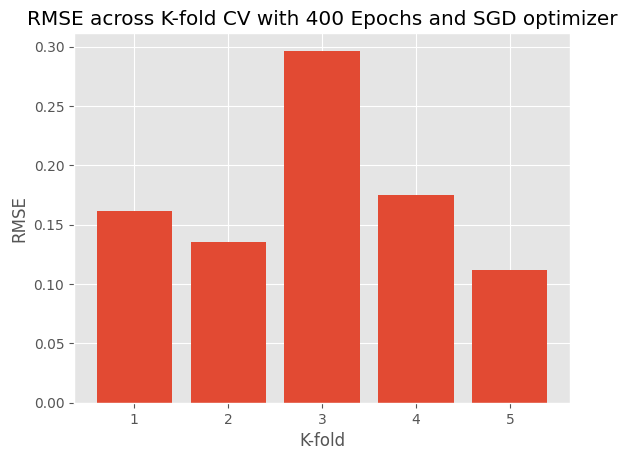

Task Runtime:  11.33  minutes
Total Runtime:  28.21  minutes
63/63 [==============================] - 0s 2ms/step


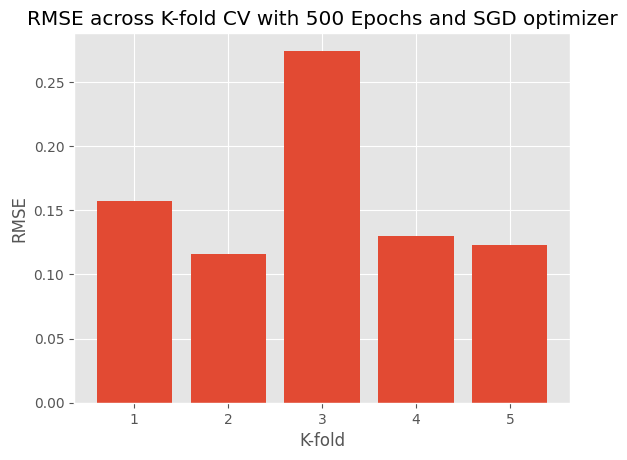

Task Runtime:  14.34  minutes
Total Runtime:  42.55  minutes


In [8]:
run_epoch_comparison(build_and_compile_model_fc,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.SGD,optim_name='SGD',cv=5)

63/63 [==============================] - 0s 2ms/step


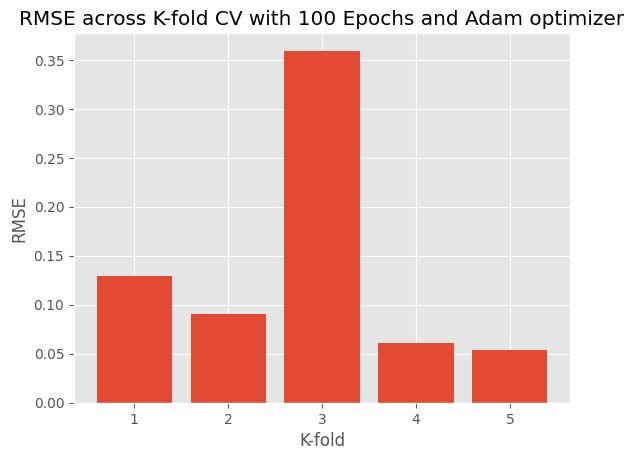

Task Runtime:  2.88  minutes
Total Runtime:  2.88  minutes
63/63 [==============================] - 0s 2ms/step


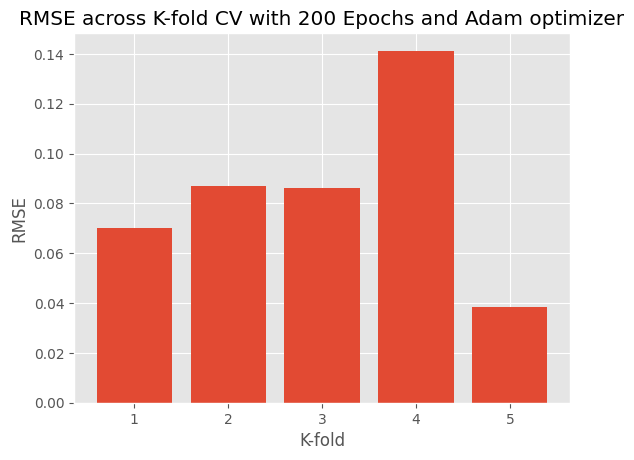

Task Runtime:  6.0  minutes
Total Runtime:  8.88  minutes
63/63 [==============================] - 0s 2ms/step


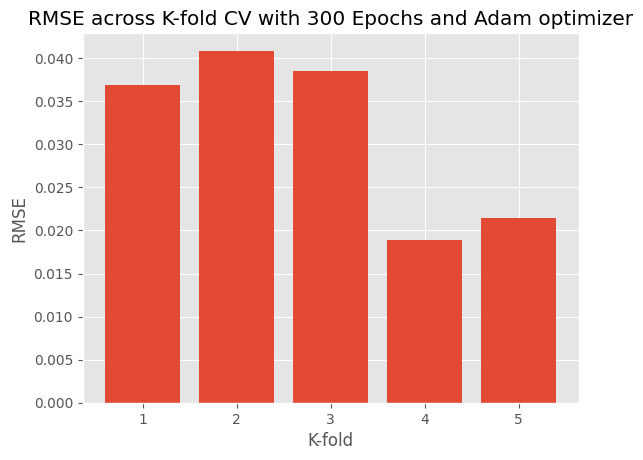

Task Runtime:  8.8  minutes
Total Runtime:  17.68  minutes
63/63 [==============================] - 0s 2ms/step


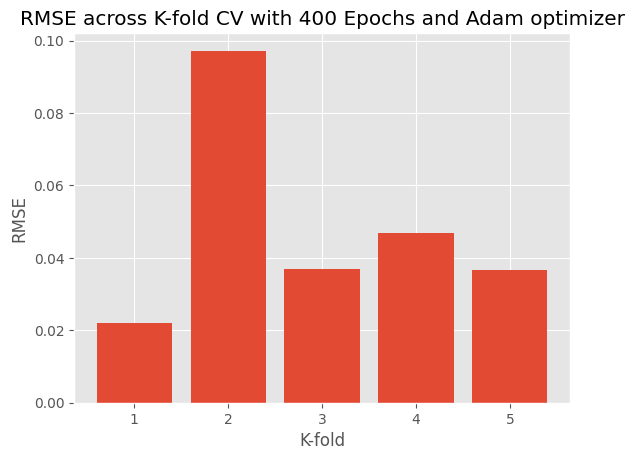

Task Runtime:  11.86  minutes
Total Runtime:  29.54  minutes
63/63 [==============================] - 0s 2ms/step


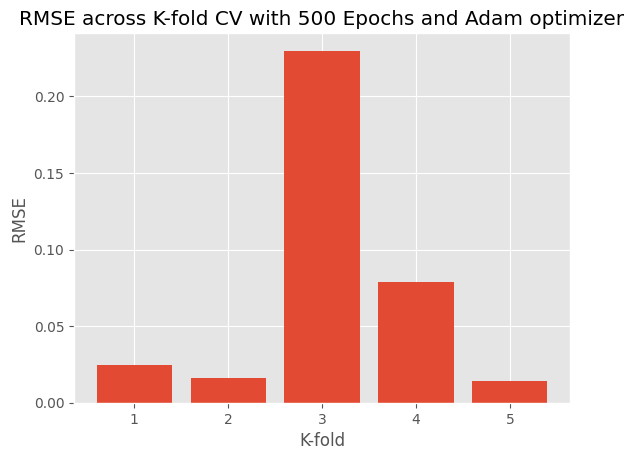

Task Runtime:  15.14  minutes
Total Runtime:  44.69  minutes


In [9]:
run_epoch_comparison(build_and_compile_model,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adam,optim_name='Adam',cv=5)

63/63 [==============================] - 0s 2ms/step


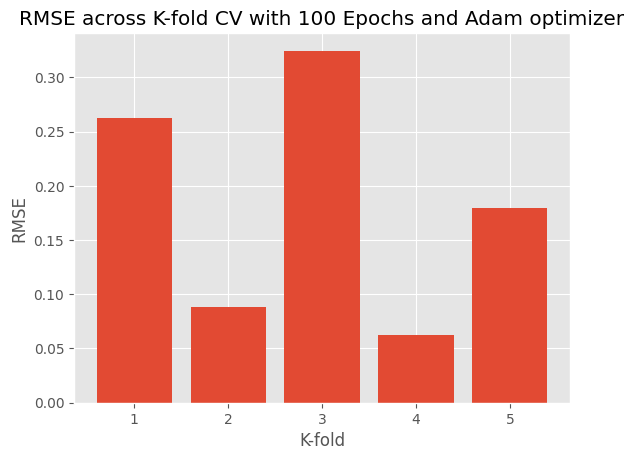

Task Runtime:  3.12  minutes
Total Runtime:  3.12  minutes
63/63 [==============================] - 0s 2ms/step


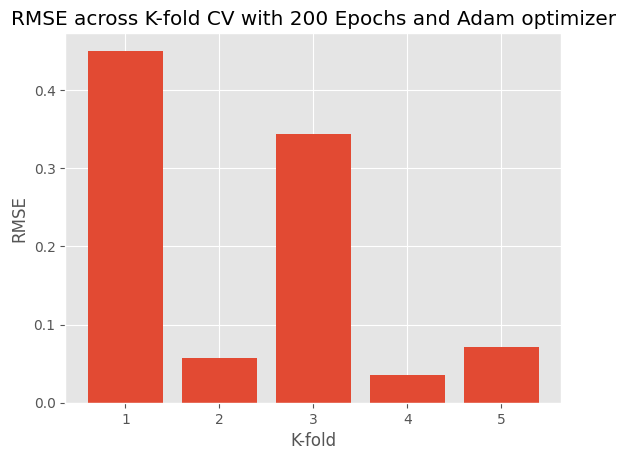

Task Runtime:  6.52  minutes
Total Runtime:  9.63  minutes
63/63 [==============================] - 0s 2ms/step


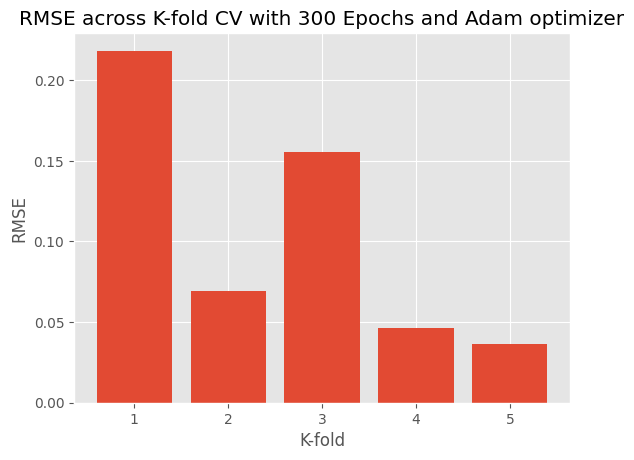

Task Runtime:  9.34  minutes
Total Runtime:  18.97  minutes
63/63 [==============================] - 0s 2ms/step


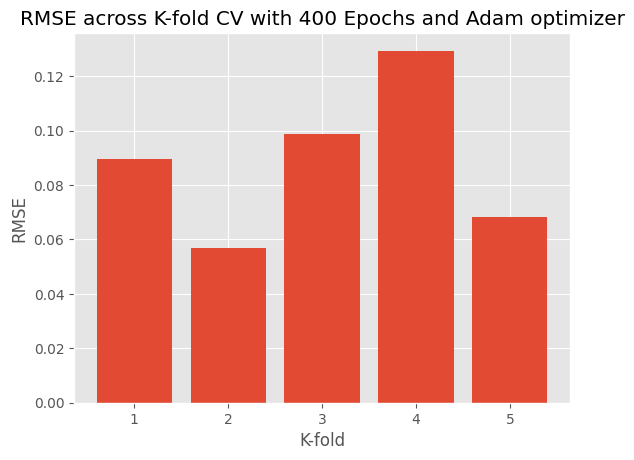

Task Runtime:  13.38  minutes
Total Runtime:  32.35  minutes
63/63 [==============================] - 0s 2ms/step


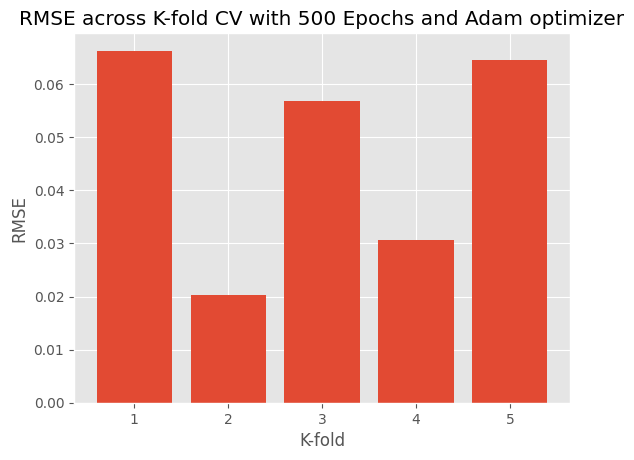

Task Runtime:  15.72  minutes
Total Runtime:  48.07  minutes


In [10]:
run_epoch_comparison(build_and_compile_model_fc,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adam,optim_name='Adam',cv=5)

63/63 [==============================] - 0s 2ms/step


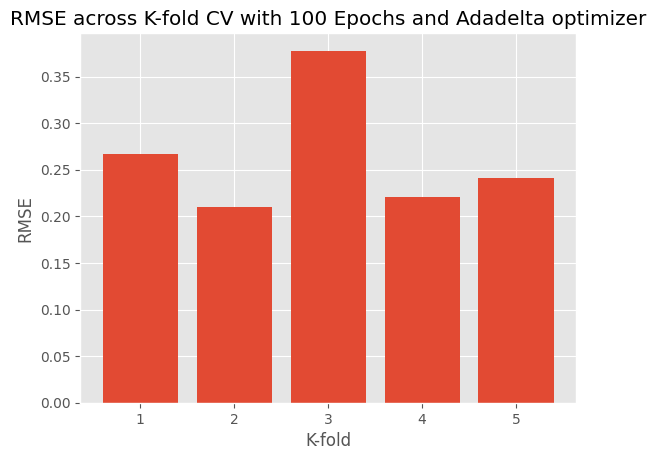

Task Runtime:  3.59  minutes
Total Runtime:  3.59  minutes
63/63 [==============================] - 0s 2ms/step


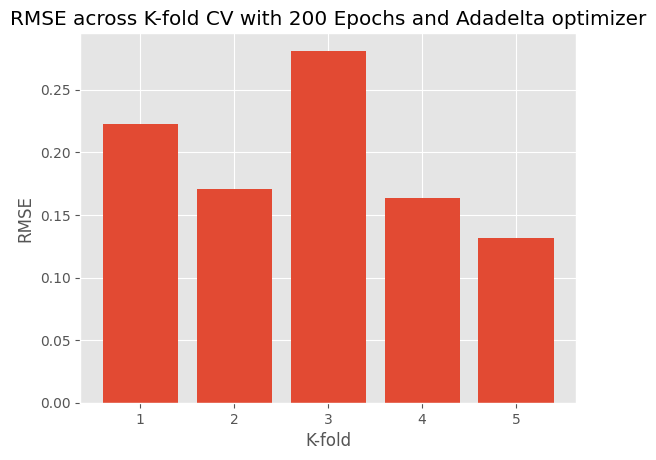

Task Runtime:  6.87  minutes
Total Runtime:  10.47  minutes
63/63 [==============================] - 0s 2ms/step


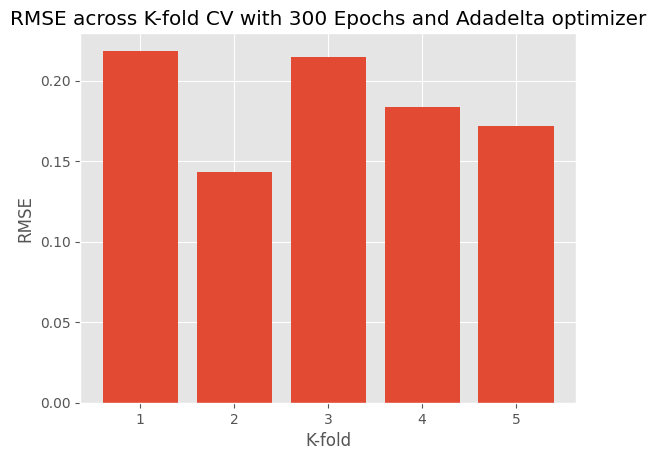

Task Runtime:  10.19  minutes
Total Runtime:  20.66  minutes
63/63 [==============================] - 0s 2ms/step


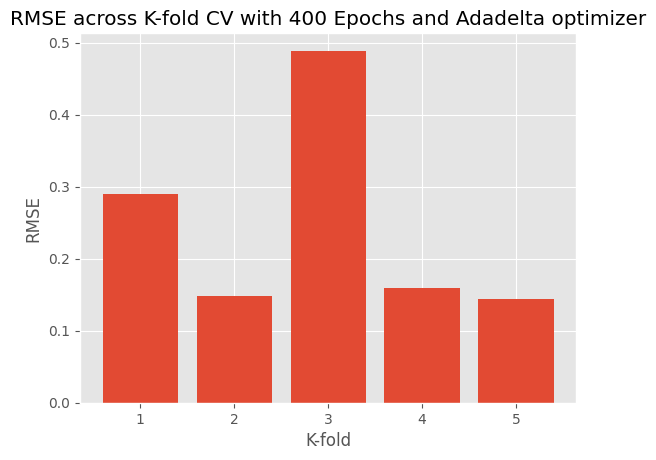

Task Runtime:  14.0  minutes
Total Runtime:  34.67  minutes
63/63 [==============================] - 0s 2ms/step


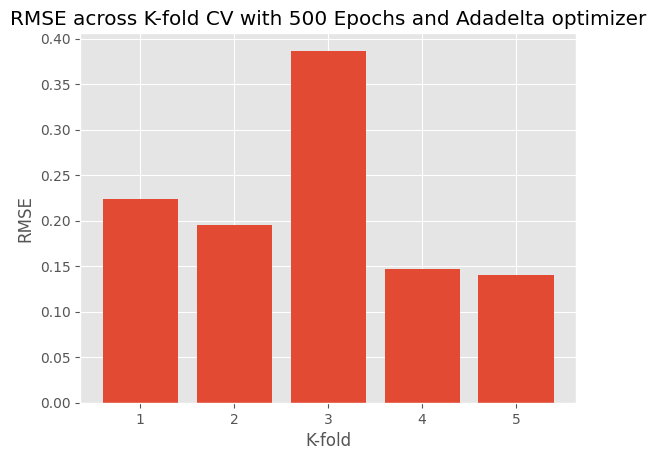

Task Runtime:  17.76  minutes
Total Runtime:  52.42  minutes


In [11]:
run_epoch_comparison(build_and_compile_model,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adadelta,optim_name='Adadelta',cv=5)

63/63 [==============================] - 0s 2ms/step


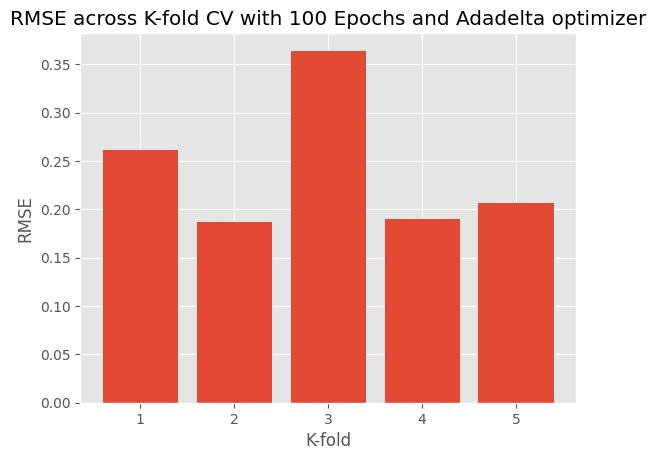

Task Runtime:  3.66  minutes
Total Runtime:  3.66  minutes
63/63 [==============================] - 0s 2ms/step


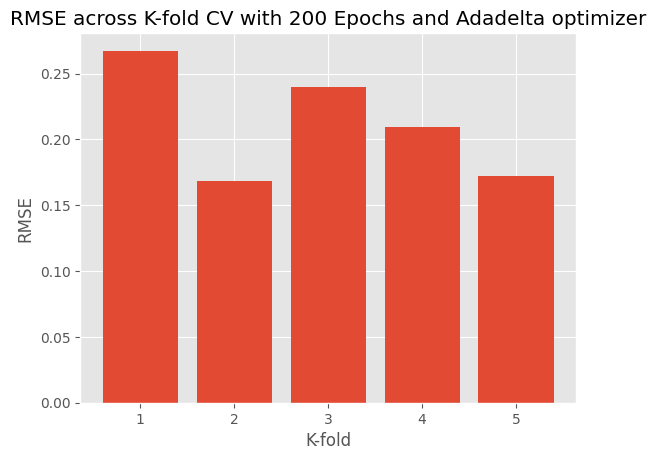

Task Runtime:  7.19  minutes
Total Runtime:  10.85  minutes
63/63 [==============================] - 0s 2ms/step


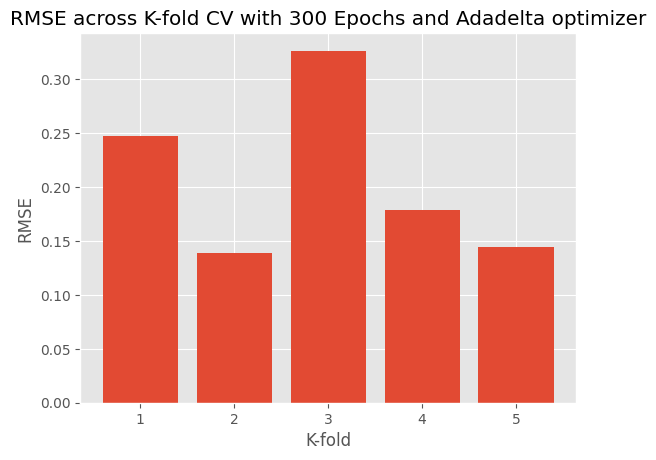

Task Runtime:  11.09  minutes
Total Runtime:  21.94  minutes
63/63 [==============================] - 0s 2ms/step


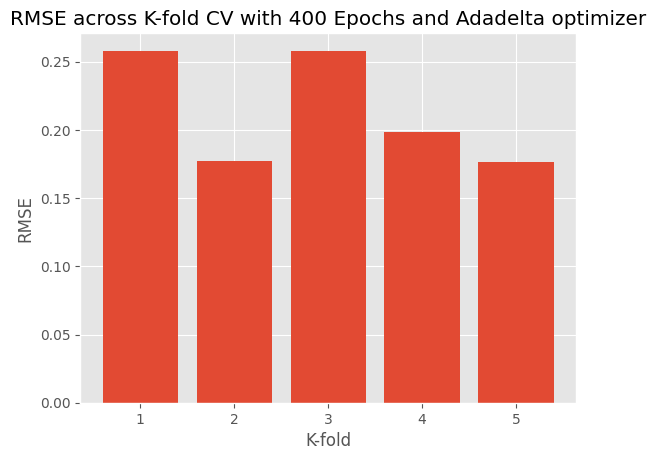

Task Runtime:  15.52  minutes
Total Runtime:  37.46  minutes
63/63 [==============================] - 0s 2ms/step


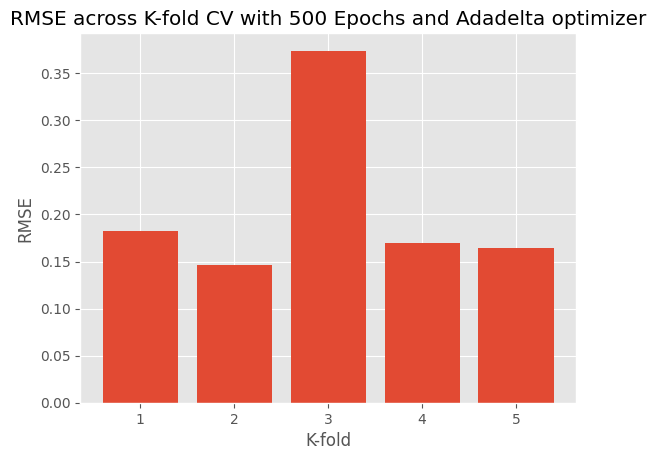

Task Runtime:  17.8  minutes
Total Runtime:  55.26  minutes


In [12]:
run_epoch_comparison(build_and_compile_model_fc,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adadelta,optim_name='Adadelta',cv=5)

63/63 [==============================] - 0s 2ms/step


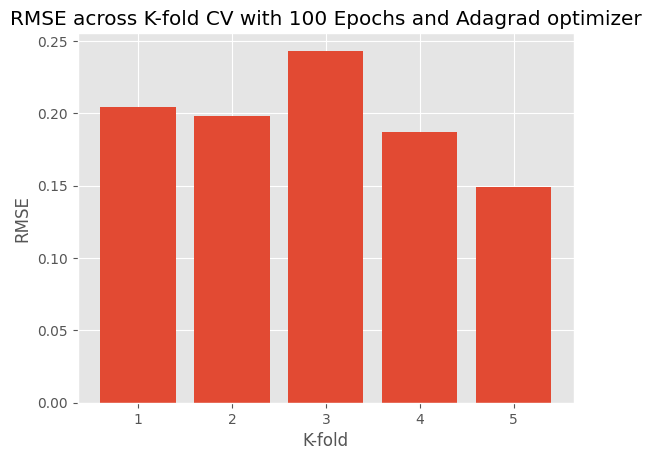

Task Runtime:  3.87  minutes
Total Runtime:  3.87  minutes
63/63 [==============================] - 0s 2ms/step


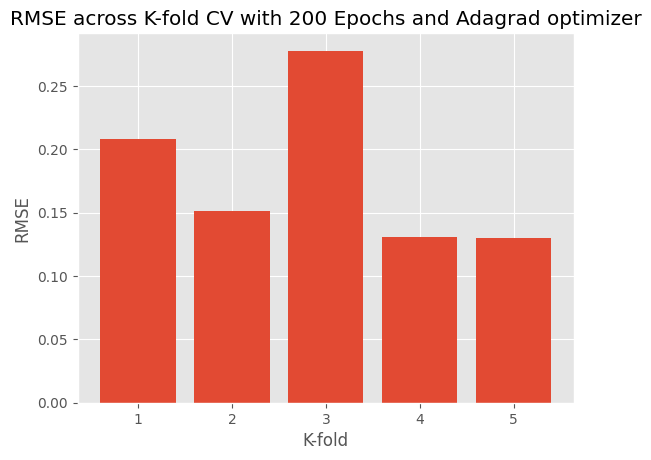

Task Runtime:  6.8  minutes
Total Runtime:  10.68  minutes
63/63 [==============================] - 0s 2ms/step


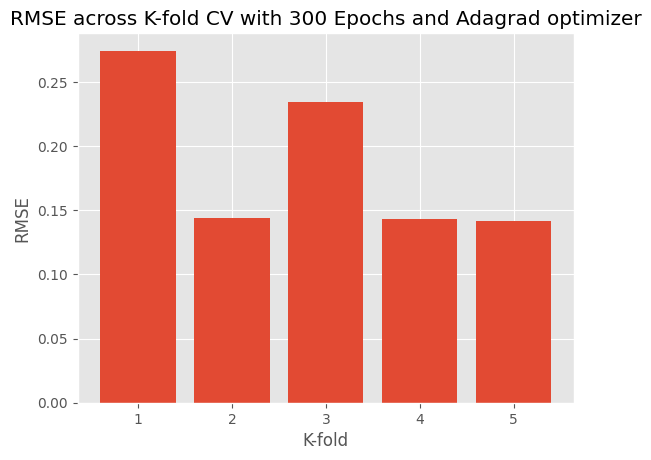

Task Runtime:  10.85  minutes
Total Runtime:  21.52  minutes
63/63 [==============================] - 0s 2ms/step


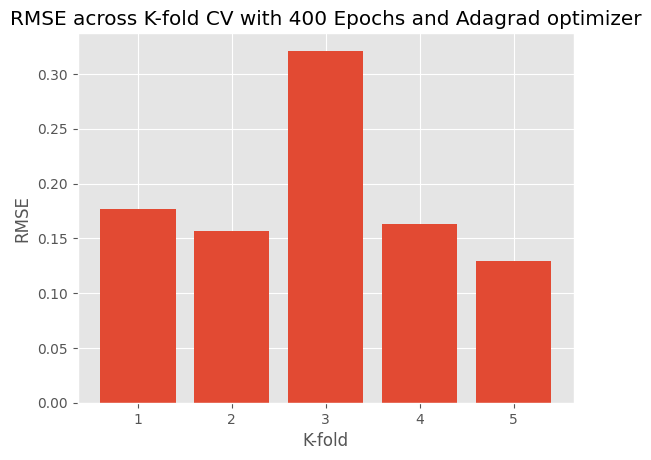

Task Runtime:  14.3  minutes
Total Runtime:  35.82  minutes
63/63 [==============================] - 0s 2ms/step


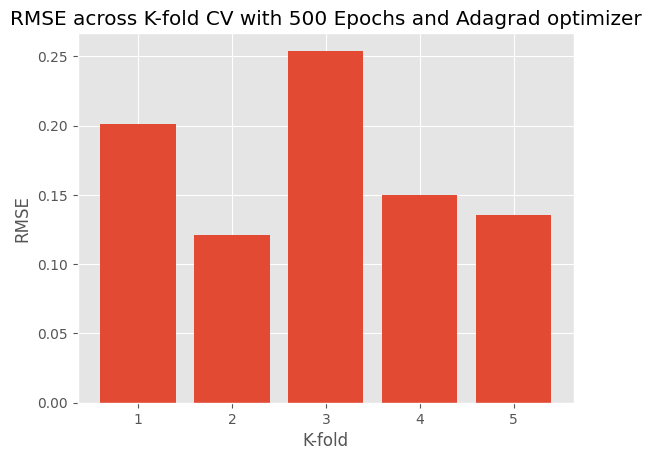

Task Runtime:  17.7  minutes
Total Runtime:  53.53  minutes


In [14]:
run_epoch_comparison(build_and_compile_model,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adagrad,optim_name='Adagrad',cv=5)

63/63 [==============================] - 0s 2ms/step


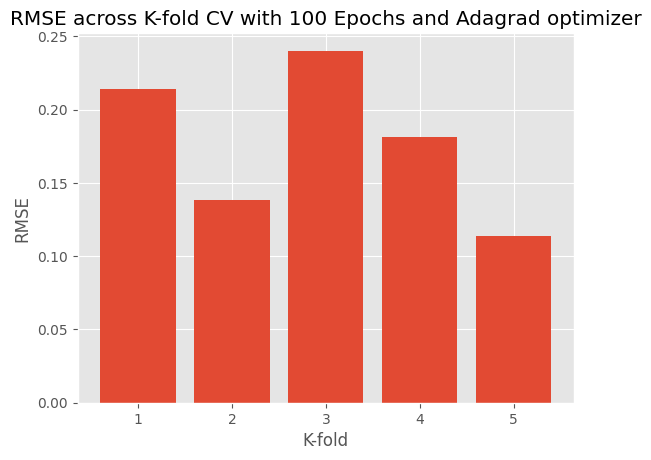

Task Runtime:  3.79  minutes
Total Runtime:  3.79  minutes
63/63 [==============================] - 0s 2ms/step


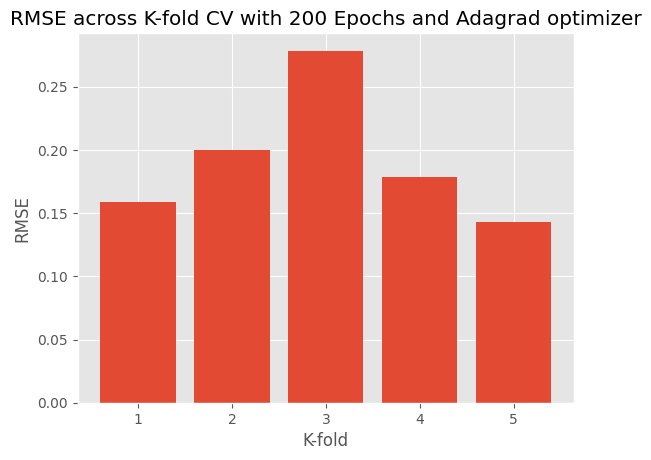

Task Runtime:  7.64  minutes
Total Runtime:  11.43  minutes
63/63 [==============================] - 0s 2ms/step


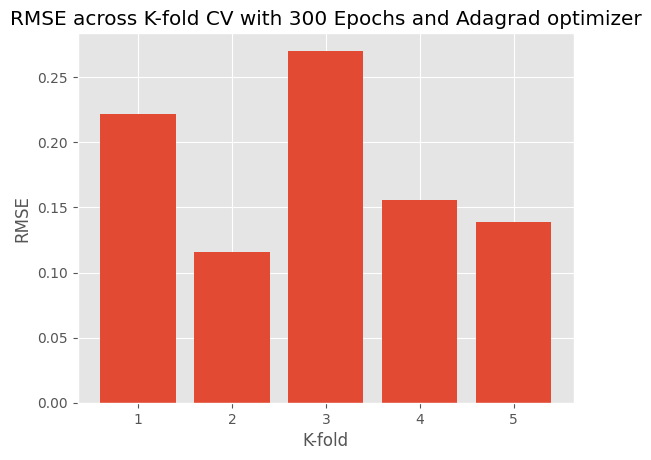

Task Runtime:  10.88  minutes
Total Runtime:  22.31  minutes
63/63 [==============================] - 0s 2ms/step


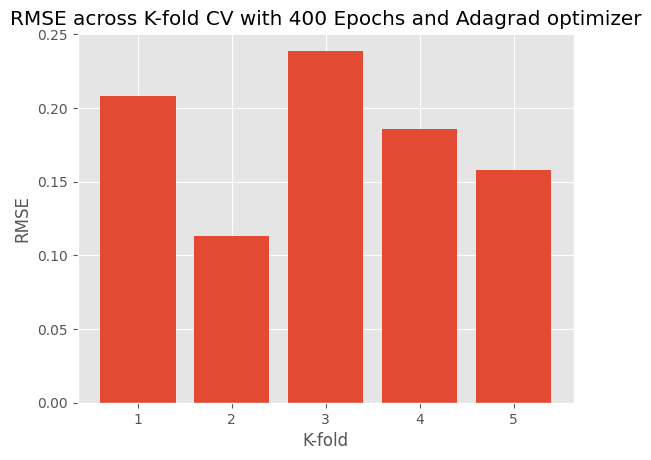

Task Runtime:  15.21  minutes
Total Runtime:  37.52  minutes
63/63 [==============================] - 0s 2ms/step


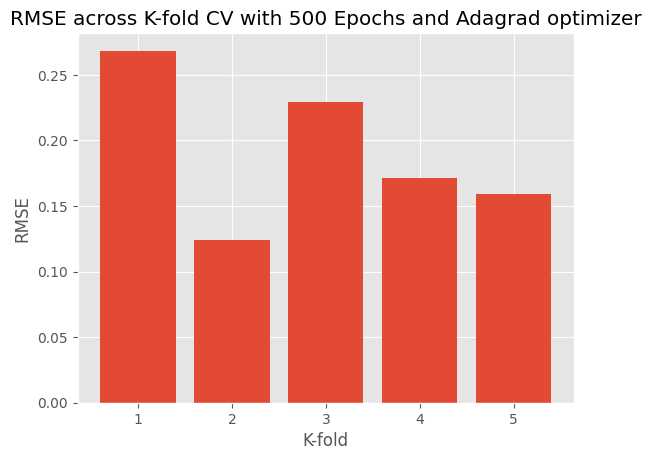

Task Runtime:  19.04  minutes
Total Runtime:  56.55  minutes


In [15]:
run_epoch_comparison(build_and_compile_model_fc,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adagrad,optim_name='Adagrad',cv=5)

63/63 [==============================] - 0s 2ms/step


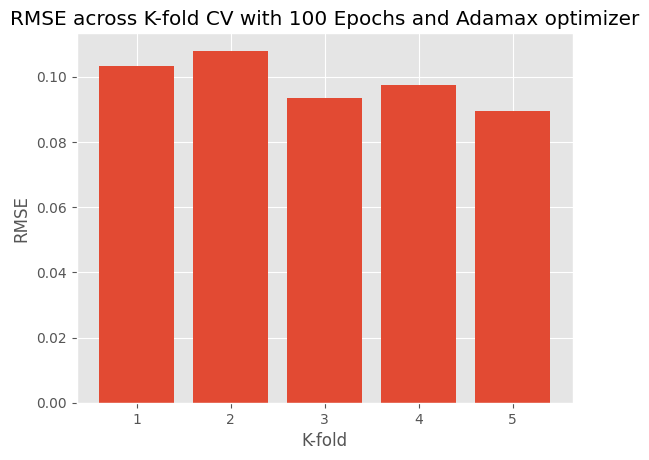

Task Runtime:  4.12  minutes
Total Runtime:  4.12  minutes
63/63 [==============================] - 0s 2ms/step


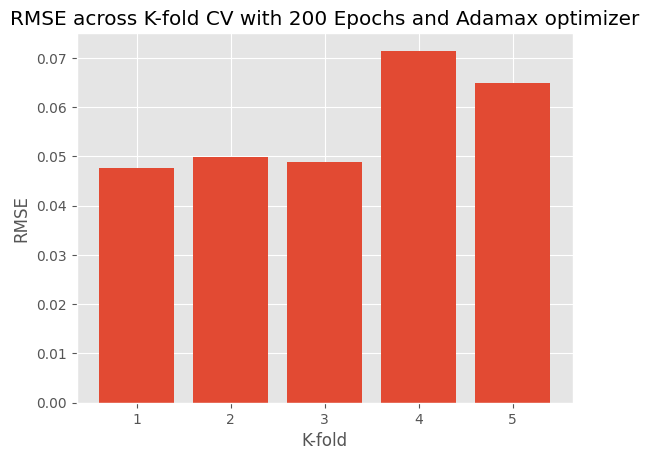

Task Runtime:  8.1  minutes
Total Runtime:  12.22  minutes
63/63 [==============================] - 0s 2ms/step


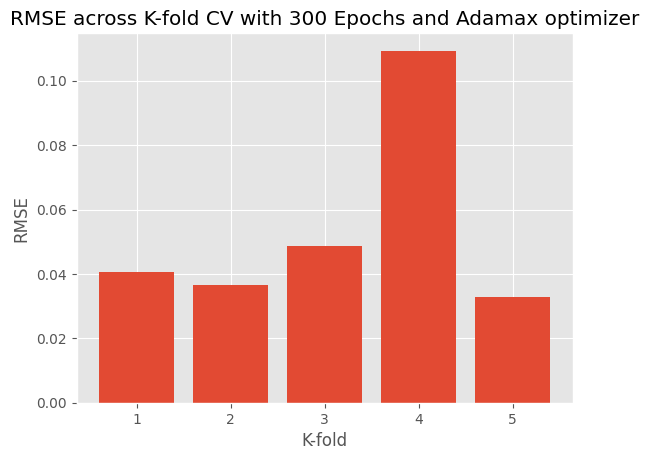

Task Runtime:  12.47  minutes
Total Runtime:  24.69  minutes
63/63 [==============================] - 0s 2ms/step


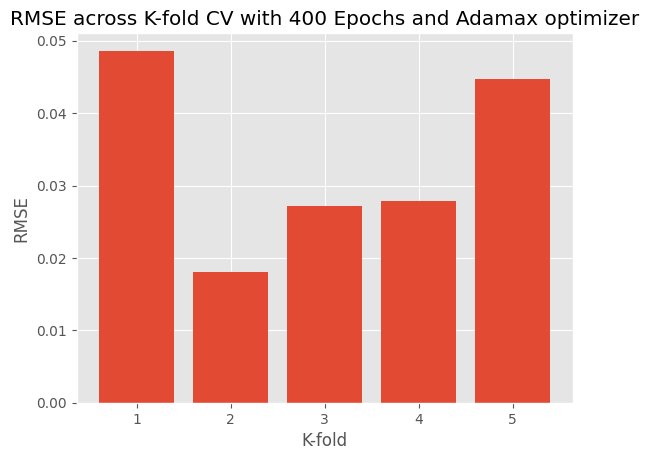

Task Runtime:  17.49  minutes
Total Runtime:  42.18  minutes
63/63 [==============================] - 0s 2ms/step


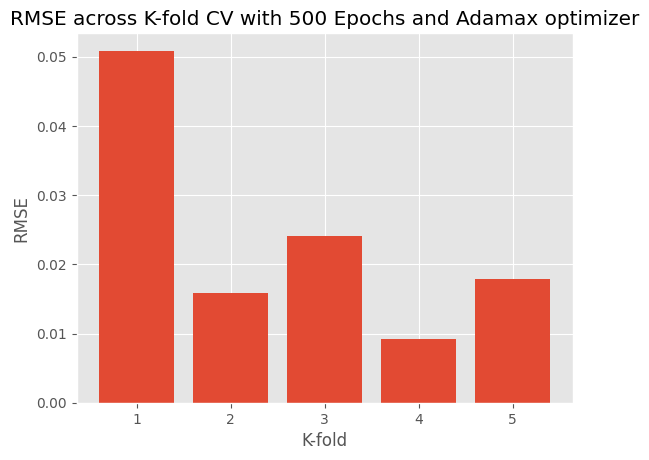

Task Runtime:  20.47  minutes
Total Runtime:  62.66  minutes


In [16]:
run_epoch_comparison(build_and_compile_model,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adamax,optim_name='Adamax',cv=5)

63/63 [==============================] - 0s 2ms/step


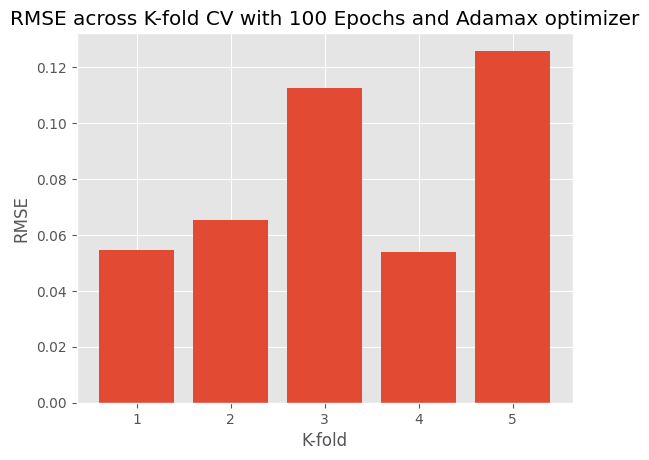

Task Runtime:  4.14  minutes
Total Runtime:  4.14  minutes
63/63 [==============================] - 0s 2ms/step


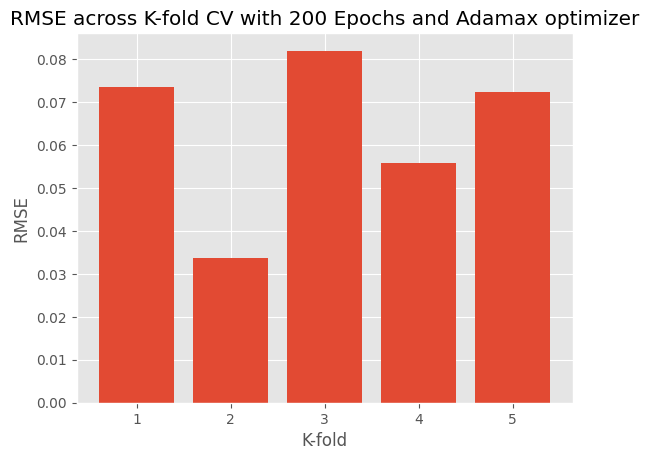

Task Runtime:  8.3  minutes
Total Runtime:  12.44  minutes
63/63 [==============================] - 0s 2ms/step


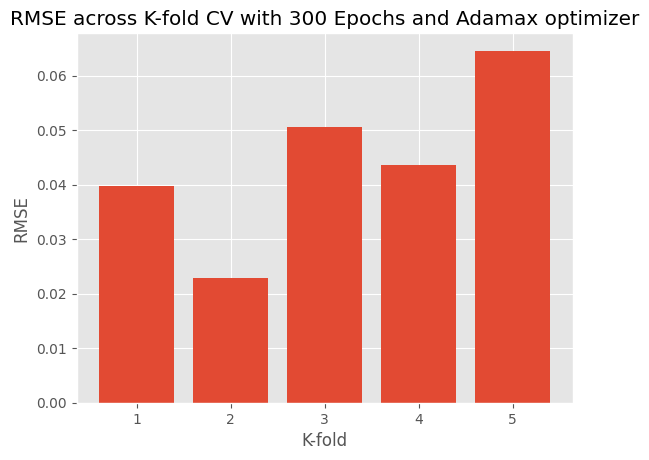

Task Runtime:  12.87  minutes
Total Runtime:  25.31  minutes
63/63 [==============================] - 0s 2ms/step


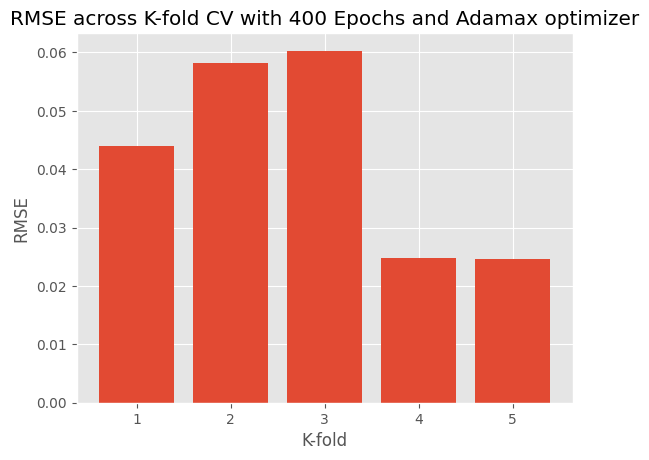

Task Runtime:  19.08  minutes
Total Runtime:  44.39  minutes
63/63 [==============================] - 0s 2ms/step


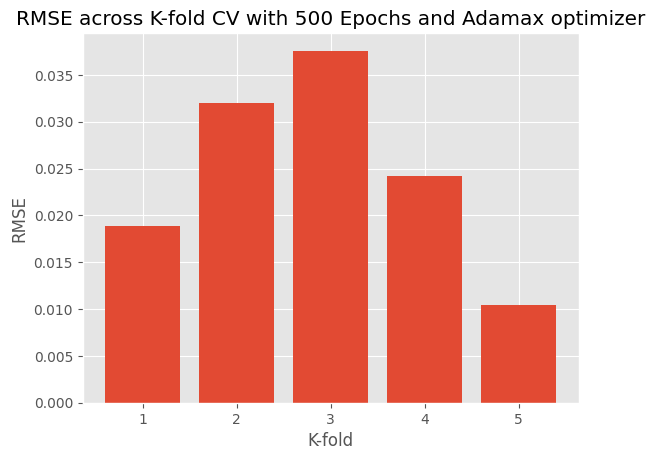

Task Runtime:  20.84  minutes
Total Runtime:  65.23  minutes


In [17]:
run_epoch_comparison(build_and_compile_model,[100,200,300,400,500],data,targets,data_normalizer,optim=tf.keras.optimizers.Adamax,optim_name='Adamax',cv=5)